### Lab 11 and 12

Implement DynaQ algorithm to solve the maze problem.

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random

In [2]:
ROWS = 7
COLS = 9
START = (0,0)
DEST = (6,8)
BLOCKS = [(2, 2), (3, 2), (4, 2), (0, 4), (6,4), (3, 6), (4, 6), (5, 8)]
ACTIONS = ["left", "up", "right", "down"]

In [3]:
class Maze:
    """
    This initializes the Maze object. The state is a tuple which represents
    the position in the object in the maze, which is the row and column. Update the state if 
    both row abd col values in the reasonable range (0 <= r <= ROWS-1, 0<= c <= CLOS-1),
    otherwise, ignore the state value.
    
    """
    def __init__(self, rows=ROWS, cols=COLS, start=START, dest=DEST, blocks=BLOCKS):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.dest = dest
        self.blocks = blocks
        self.state = start
        self.end = False
        # init maze
        self.maze = np.zeros((self.rows, self.cols))
        for b in self.blocks:
            self.maze[b] = -1
            
    def nxtState(self, action):
        r, c = self.state
        if action == "left":
            c -= 1
        elif action == "right":
            c += 1
        elif action == "up":
            r -= 1
        else:
            r += 1
        
        if (r >= 0 and r <= self.rows-1) and (c >= 0 and c <= self.cols-1):
            if (r, c) not in self.blocks:
                self.state = (r, c)
        return self.state
    
    def giveReward(self):
        if self.state == self.dest:
            self.end = True
            return 1
        else:
            return 0
        
    def showMaze(self):
        self.maze[self.state] = 1
        for i in range(0, self.rows):
            print('-------------------------------------')
            output = '| '
            for j in range(0, self.cols):
                if self.maze[i, j] == 1:
                    obj = '*'
                if self.maze[i, j] == -1:
                    obj = 'z'
                if self.maze[i, j] == 0:
                    obj = '0'
                output += obj + ' | '
            print(output)
        print('-------------------------------------')

In [4]:
m = Maze()
m.showMaze()

-------------------------------------
| * | 0 | 0 | 0 | z | 0 | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | z | 0 | 0 | 
-------------------------------------
| 0 | 0 | z | 0 | 0 | 0 | z | 0 | 0 | 
-------------------------------------
| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | z | 
-------------------------------------
| 0 | 0 | 0 | 0 | z | 0 | 0 | 0 | 0 | 
-------------------------------------


In [37]:
class DynaQ:
    
    def __init__(self, maze, exp_rate=0.3, lr=0.1, n_plannings=5, episodes=1):
        self.maze = maze
        self.state = START
        self.actions = ACTIONS
        self.state_actions = []  # state & action track
        self.exp_rate = exp_rate
        self.lr = lr
        
        self.n_plannings = n_plannings
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []
        
        self.Q_values = {}
        # model function
        self.model = {}
        for row in range(ROWS):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0
        
    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""
        
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][a]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action
    
    def reset(self):
        self.maze = Maze()
        self.state = START
        self.state_actions = []
    
    def play(self):
        self.steps_per_episode = []  
        
        for ep in range(self.episodes):    
            while not self.maze.end:

                action = self.chooseAction()
                self.state_actions.append((self.state, action))

                nxtState = self.maze.nxtState(action)
                reward = self.maze.giveReward()
                # update Q-value
                self.Q_values[self.state][action] += self.lr*(reward + np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action])

                # update model
                if self.state not in self.model.keys():
                    self.model[self.state] = {}
                self.model[self.state][action] = (reward, nxtState)
                self.state = nxtState

                # loop n times to randomly update Q-value
                for _ in range(self.n_plannings):
                    # randomly choose an state
                    rand_idx = np.random.choice(range(len(self.model.keys())))
                    _state = list(self.model)[rand_idx]
                    # randomly choose an action
                    rand_idx = np.random.choice(range(len(self.model[_state].keys())))
                    _action = list(self.model[_state])[rand_idx]

                    _reward, _nxtState = self.model[_state][_action]

                    self.Q_values[_state][_action] += self.lr*(_reward + np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])       
            # end of game
            if ep % 10 == 0:
                print("episode", ep)
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()
                  

In [38]:
N_EPISODES = 50

In [39]:
dyna = DynaQ(m, n_plannings=0, episodes=N_EPISODES)
dyna.play()

steps_episode_0 = dyna.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [40]:
dyna5 = DynaQ(m, n_plannings=5, episodes=N_EPISODES)
dyna5.play()

steps_episode_5 = dyna5.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


In [41]:
dyna50 = DynaQ(m, n_plannings=50, episodes=N_EPISODES)
dyna50.play()

steps_episode_50 = dyna50.steps_per_episode

episode 0
episode 10
episode 20
episode 30
episode 40


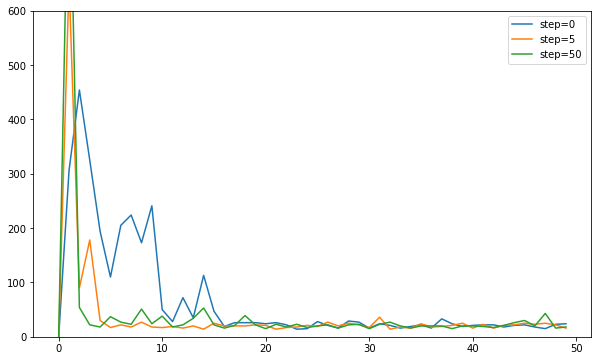

In [42]:
plt.figure(figsize=[10, 6])

plt.ylim(0, 600)
plt.plot(range(N_EPISODES), steps_episode_0, label="step=0")
plt.plot(range(N_EPISODES), steps_episode_5, label="step=5")
plt.plot(range(N_EPISODES), steps_episode_50, label="step=50")

plt.legend()

### Exercise 8.2

Why did the Dyna agent with exploration bonus, Dyna-Q+, perform better in the first phase as well as in the second phase of the blocking and shortcut experiments?

This is a question for you to think about when you are working on the assignment 4 Question 2.